In [1]:
#import os
#os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.25"
import jax
import juniper as jp

from juniper.configurables import Gaussian
from juniper.configurables import LateralKernel

from juniper.dynamics import NeuralField
from juniper.statics import StaticGain
from juniper.sources import DemoInput
from juniper.statics import Projection


from demo.demoMemoryGame import demoMemoryGame

In [2]:
print(jax.local_devices())

[CpuDevice(id=0)]


In [3]:
arch = jp.Architecture.get_arch()

<img src="demo/img/memory_game.drawio.png" width="1500">

In [ ]:
jp.Architecture.delete_arch()
arch = jp.Architecture.get_arch()
shape0D = (1,)
shape1D = (6,)
shape2D = (29, 45)
shape3D = (29, 45, 6)

set_cl4 = False

#steps
demo_input = []
for i in range(12):
    demo_input.append(DemoInput("in"+str(i), {"shape":shape3D, "sigma":(1,1,0.1), "amplitude":1, "center": (5,5,1)}))

nf_kernel = Gaussian({"sigma": (3,3,0.01), "amplitude": 1, "normalized": True})
nf_sfm = NeuralField("Shape Space/Feature Map", {"shape": shape3D, "resting_level": -0.9, "global_inhibition": -0.0, "tau": 0.02, "input_noise_gain": 0.0, "sigmoid": "AbsSigmoid", "beta": 100, "theta":0, "LateralKernel": nf_kernel})

nf_kernel = LateralKernel({"kernels": [Gaussian({"sigma": (3,3,0.01), "amplitude": 0.75, "normalized": True}), Gaussian({"sigma": (3,3,1), "amplitude": -1.5, "normalized": True})]})
nf_sfs = NeuralField("Shape Scene Selection", {"shape": shape3D, "resting_level": -1.9, "global_inhibition": -0.0, "tau": 0.4, "input_noise_gain": 0.0, "sigmoid": "AbsSigmoid", "beta": 100, "theta":0, "LateralKernel": nf_kernel})
p4 = Projection("p4", {"input_shape":shape3D, "output_shape":shape1D, "axis":(0,1), "order":(0,), "compression_type": "Maximum"}) 

p1 = Projection("p1", {"input_shape":shape3D, "output_shape":shape2D, "axis":(2,), "order":(0,1), "compression_type": "Maximum"})    
nf_kernel = LateralKernel({"kernels": [Gaussian({"sigma": (2,2), "amplitude": 1, "normalized": True}), Gaussian({"sigma": (3,3), "amplitude": -0.5, "normalized": True})]})
nf_salmap = NeuralField("Salience Map", {"shape": shape2D, "resting_level": -0.5, "global_inhibition": -0.0, "tau": 0.02, "input_noise_gain": 0.0, "sigmoid": "AbsSigmoid", "beta": 100, "theta":0, "LateralKernel": nf_kernel})
st0 = StaticGain("st0", {"factor": 3})

p2 = Projection("p2", {"input_shape":shape2D, "output_shape":shape0D, "axis":(0,1), "order":(), "compression_type": "Maximum"})  
nf_kernel = Gaussian({"sigma": (0.01,), "amplitude": 0.2, "normalized": False})
nn_salmap_pd = NeuralField("Salience Map PD", {"shape": shape0D, "resting_level": -0.9, "global_inhibition": -0.0, "tau": 0.04, "input_noise_gain": 0.0, "sigmoid": "AbsSigmoid", "beta": 9001, "theta":0, "LateralKernel": nf_kernel})
st1 = StaticGain("st1", {"factor": 11})

nf_kernel = Gaussian({"sigma": (0.01,), "amplitude": 1.0, "normalized": False})
nn_intex = NeuralField("Intention Explore", {"shape": shape0D, "resting_level": -10.5, "global_inhibition": -0.0, "tau": 0.08, "input_noise_gain": 0.0, "sigmoid": "AbsSigmoid", "beta": 500, "theta":0, "LateralKernel": nf_kernel})
st2 = StaticGain("st2", {"factor": 10})

nf_kernel = Gaussian({"sigma": (1,1), "amplitude": 15, "normalized": False})
nf_attsel = NeuralField("Attentional Selection", {"shape": shape2D, "resting_level": -13.0, "global_inhibition": -3.0, "tau": 0.06, "input_noise_gain": 0.4, "sigmoid": "AbsSigmoid", "beta": 9001, "theta":0, "LateralKernel": nf_kernel})
p3 = Projection("p3", {"input_shape":shape2D, "output_shape":shape3D, "axis":(2,), "order":(0,1,2), "compression_type": "Maximum"}) 
p13 = Projection("p13", {"input_shape":shape2D, "output_shape":shape0D, "axis":(0,1), "order":(), "compression_type": "Maximum"}) 

nf_kernel = Gaussian({"sigma": (0.5,0.5), "amplitude": 1.5, "normalized": False})
nf_ior = NeuralField("IOR", {"shape": shape2D, "resting_level": -0.5, "global_inhibition": -0.0, "tau": 0.2, "input_noise_gain": 0.0, "sigmoid": "AbsSigmoid", "beta": 9001, "theta":0, "LateralKernel": nf_kernel})
st3 = StaticGain("st3", {"factor": -1})

nf_kernel = Gaussian({"sigma": (0.01,), "amplitude": 1.0, "normalized": True})
nf_attfea = NeuralField("Attended Feature", {"shape": shape1D, "resting_level": -0.9, "global_inhibition": -0.0, "tau": 0.1, "input_noise_gain": 0.0, "sigmoid": "AbsSigmoid", "beta": 100, "theta":0, "LateralKernel": nf_kernel})
p5 = Projection("p5", {"input_shape":shape1D, "output_shape":shape3D, "axis":(0,1), "order":(0,1,2), "compression_type": "Maximum"}) 
st5 = StaticGain("st5", {"factor": 0.8})

if set_cl4:
    nf_kernel = Gaussian({"sigma": (0.5,0.5,0.01), "amplitude": 2.6, "normalized": True})
    nf_ssm = NeuralField("Shape Scene Memory", {"shape": shape3D, "resting_level": -0.9, "global_inhibition": -0.017, "tau": 0.04, "input_noise_gain": 0.3, "sigmoid": "AbsSigmoid", "beta": 100, "theta":0, "LateralKernel": nf_kernel})
else:
    nf_kernel = LateralKernel({"kernels": [Gaussian({"sigma": (0.5,0.5,0.01), "amplitude": 3.0, "normalized": True}), Gaussian({"sigma": (1.5,1.5,0.01), "amplitude": -0.5, "normalized": True})]})
    nf_ssm = NeuralField("Shape Scene Memory", {"shape": shape3D, "resting_level": -1.6, "global_inhibition": -0.0, "tau": 0.04, "input_noise_gain": 0.0, "sigmoid": "AbsSigmoid", "beta": 100, "theta":0, "LateralKernel": nf_kernel})

st4 = StaticGain("st4", {"factor": 1.1})
p14 = Projection("p14", {"input_shape":shape3D, "output_shape":shape2D, "axis":(2), "order":(0,1), "compression_type": "Maximum"})

nf_kernel = LateralKernel({"kernels": [Gaussian({"sigma": (2,2,0.01), "amplitude": 0.75, "normalized": True}), Gaussian({"sigma": (3,3,1), "amplitude": -1.5, "normalized": True})]})
nf_ssms = NeuralField("Shape Scene Memory Selection", {"shape": shape3D, "resting_level": -1.9, "global_inhibition": -0.0, "tau": 0.4, "input_noise_gain": 0.0, "sigmoid": "AbsSigmoid", "beta": 100, "theta":0, "LateralKernel": nf_kernel})
p6 = Projection("p6", {"input_shape":shape3D, "output_shape":shape1D, "axis":(0,1), "order":(0,), "compression_type": "Maximum"}) 

nf_kernel = Gaussian({"sigma": (0.01,), "amplitude": 1.0, "normalized": True})
nf_expfea = NeuralField("Expected Feature", {"shape": shape1D, "resting_level": -0.9, "global_inhibition": -0.0, "tau": 0.1, "input_noise_gain": 0.0, "sigmoid": "AbsSigmoid", "beta": 100, "theta":0, "LateralKernel": nf_kernel})

nf_kernel = Gaussian({"sigma": (0.5,), "amplitude": 1.0, "normalized": True})
nf_mmd = NeuralField("Memory Match Detection", {"shape": shape1D, "resting_level": -1.9, "global_inhibition": -0.0, "tau": 0.2, "input_noise_gain": 0.0, "sigmoid": "AbsSigmoid", "beta": 100, "theta":0, "LateralKernel": nf_kernel})
p7 = Projection("p7", {"input_shape":shape1D, "output_shape":shape0D, "axis":(0,), "order":(), "compression_type": "Maximum"}) 

nf_kernel = Gaussian({"sigma": (0.01,), "amplitude": 0.2, "normalized": False})
nn_cosex = NeuralField("CoS Explore", {"shape": shape0D, "resting_level": -1.5, "global_inhibition": -0.0, "tau": 0.2, "input_noise_gain": 0.0, "sigmoid": "AbsSigmoid", "beta": 9001, "theta":0, "LateralKernel": nf_kernel})
st6 = StaticGain("st6", {"factor": -50})

nf_kernel = Gaussian({"sigma": (3,3), "amplitude": 1, "normalized": True})
nf_offset1 = NeuralField("Offset1", {"shape": shape2D, "resting_level": -0.9, "global_inhibition": -0.0, "tau": 0.02, "input_noise_gain": 0.0, "sigmoid": "AbsSigmoid", "beta": 100, "theta":0, "LateralKernel": nf_kernel})
nf_offset2 = NeuralField("Offset2", {"shape": shape2D, "resting_level": -0.9, "global_inhibition": -0.0, "tau": 0.8, "input_noise_gain": 0.0, "sigmoid": "AbsSigmoid", "beta": 100, "theta":0, "LateralKernel": nf_kernel})
st7 = StaticGain("st7", {"factor": -1})
p8 = Projection("p8", {"input_shape":shape2D, "output_shape":shape0D, "axis":(0,1), "order":(), "compression_type": "Maximum"})  

nf_kernel = Gaussian({"sigma": (0.01,), "amplitude": 0.2, "normalized": False})
nn_offset_pd = NeuralField("Offset PD", {"shape": shape0D, "resting_level": -0.5, "global_inhibition": -0.0, "tau": 0.02, "input_noise_gain": 0.0, "sigmoid": "AbsSigmoid", "beta": 9001, "theta":0, "LateralKernel": nf_kernel})
st8 = StaticGain("st8", {"factor": -50})

nf_kernel = Gaussian({"sigma": (0.01,), "amplitude": 30, "normalized": False})
nn_game = NeuralField("Game Start", {"shape": shape0D, "resting_level": -0.5, "global_inhibition": -0.0, "tau": 0.02, "input_noise_gain": 0.0, "sigmoid": "AbsSigmoid", "beta": 9001, "theta":0, "LateralKernel": nf_kernel})
st9 = StaticGain("st9", {"factor": -50})
st10 = StaticGain("st10", {"factor": 11})

nf_kernel = Gaussian({"sigma": (1,1,0.01), "amplitude": 1, "normalized": True})
nf_mgscm = NeuralField("Memory Guidance Shape Cue Map", {"shape": shape3D, "resting_level": -1.7, "global_inhibition": -0.0, "tau": 0.4, "input_noise_gain": 0.0, "sigmoid": "AbsSigmoid", "beta": 100, "theta":0, "LateralKernel": nf_kernel})
p9 = Projection("p9", {"input_shape":shape3D, "output_shape":shape2D, "axis":(2), "order":(0,1), "compression_type": "Maximum"}) 

nf_kernel = Gaussian({"sigma": (2,2), "amplitude": 0.5, "normalized": True})
nf_mgsm = NeuralField("Memory Guidance Spatial Map", {"shape": shape2D, "resting_level": -1.9, "global_inhibition": -0.0, "tau": 0.02, "input_noise_gain": 0.0, "sigmoid": "AbsSigmoid", "beta": 100, "theta":0, "LateralKernel": nf_kernel})
st11 = StaticGain("st11", {"factor": 0.4})

nf_kernel = Gaussian({"sigma": (2,2), "amplitude": 0.5, "normalized": True})
nf_msim = NeuralField("Memory Spatial Inhibtion Map", {"shape": shape2D, "resting_level": -1.9, "global_inhibition": -0.0, "tau": 0.02, "input_noise_gain": 0.0, "sigmoid": "AbsSigmoid", "beta": 100, "theta":0, "LateralKernel": nf_kernel})
st22 = StaticGain("st22", {"factor": -0.2})

nf_kernel = Gaussian({"sigma": (0.01,), "amplitude": 30, "normalized": True})
nf_cuewm = NeuralField("Cue WM", {"shape": shape1D, "resting_level": -1.9, "global_inhibition": -0.0, "tau": 0.1, "input_noise_gain": 0.0, "sigmoid": "AbsSigmoid", "beta": 100, "theta":0, "LateralKernel": nf_kernel})
p10 = Projection("p10", {"input_shape":shape1D, "output_shape":shape3D, "axis":(0,1), "order":(0,1,2), "compression_type": "Maximum"}) 
p11 = Projection("p11", {"input_shape":shape1D, "output_shape":shape0D, "axis":(0,), "order":(), "compression_type": "Maximum"}) 

nn_intff = NeuralField("Intention Find First", {"shape": shape0D, "resting_level": -10.5, "global_inhibition": -0.0, "tau": 0.8, "input_noise_gain": 0.0, "sigmoid": "AbsSigmoid", "beta": 500, "theta":0})
st12 = StaticGain("st12", {"factor": 10})

nf_kernel = Gaussian({"sigma": (0.01,), "amplitude": 0.2, "normalized": False})
nn_cosff = NeuralField("CoS Find First", {"shape": shape0D, "resting_level": -1.5, "global_inhibition": -0.0, "tau": 0.2, "input_noise_gain": 0.0, "sigmoid": "AbsSigmoid", "beta": 9001, "theta":0, "LateralKernel": nf_kernel})
st13 = StaticGain("st13", {"factor": -50})
st14 = StaticGain("st14", {"factor": 11})

nf_kernel = Gaussian({"sigma": (0.01,), "amplitude": 30, "normalized": True})
nn_cosffwm = NeuralField("CoS Find First WM", {"shape": shape0D, "resting_level": -0.5, "global_inhibition": -0.0, "tau": 0.2, "input_noise_gain": 0.0, "sigmoid": "AbsSigmoid", "beta": 9001, "theta":0, "LateralKernel": nf_kernel})
st18 = StaticGain("st18", {"factor": -50})

nn_intfs = NeuralField("Intention Find Same", {"shape": shape0D, "resting_level": -10.5, "global_inhibition": -0.0, "tau": 0.8, "input_noise_gain": 0.0, "sigmoid": "AbsSigmoid", "beta": 500, "theta":0})
st15 = StaticGain("st15", {"factor": 10})

nf_kernel = Gaussian({"sigma": (0.5,), "amplitude": 1.0, "normalized": True})
nf_samedetect = NeuralField("Same Detector", {"shape": shape1D, "resting_level": -2.9, "global_inhibition": -0.0, "tau": 0.1, "input_noise_gain": 0.0, "sigmoid": "AbsSigmoid", "beta": 100, "theta":0, "LateralKernel": nf_kernel})
p12 = Projection("p12", {"input_shape":shape1D, "output_shape":shape0D, "axis":(0,), "order":(), "compression_type": "Maximum"}) 

nf_kernel = Gaussian({"sigma": (0.01,), "amplitude": 0.2, "normalized": False})
nn_cossame = NeuralField("CoS Same", {"shape": shape0D, "resting_level": -2.9, "global_inhibition": -0.0, "tau": 0.2, "input_noise_gain": 0.0, "sigmoid": "AbsSigmoid", "beta": 9001, "theta":0, "LateralKernel": nf_kernel})
nn_codsame = NeuralField("CoD Same", {"shape": shape0D, "resting_level": -1.9, "global_inhibition": -0.0, "tau": 1.0, "input_noise_gain": 0.0, "sigmoid": "AbsSigmoid", "beta": 9001, "theta":0, "LateralKernel": nf_kernel})
nf_kernel = Gaussian({"sigma": (0.01,), "amplitude": 30, "normalized": True})
nn_cosdsamewm = NeuralField("CoS/D Same WM", {"shape": shape0D, "resting_level": -0.5, "global_inhibition": -0.0, "tau": 0.02, "input_noise_gain": 0.0, "sigmoid": "AbsSigmoid", "beta": 9001, "theta":0, "LateralKernel": nf_kernel})
st19 = StaticGain("st19", {"factor": -2})
st20 = StaticGain("st20", {"factor": -2})
st16 = StaticGain("st16", {"factor": -40})
st21 = StaticGain("st21", {"factor": -50})

#connections
for i in range(12):
    demo_input[i] >> nf_sfm
nf_sfm >> nf_sfs >> p4 >> nf_attfea >> p5 >> st5 >> nf_ssm >> nf_mgscm >> p9 >> nf_mgsm >> st11 >> nf_attsel >> p13
nf_sfm >> p1 >> nf_salmap >> st0 >> nf_attsel
nf_salmap >> p2 >> nn_salmap_pd >> st1 >> nn_intex >> st2 >> nf_attsel >> nf_ior >> st3 >> nf_attsel >> p3 >> nf_sfs
nf_ssm >> nf_ssms
p3 >> nf_ssms
nf_ssm >> p14 >> nf_msim >> st22 >> nf_attsel
p3 >> st4 >> nf_ssm >> p6 >> nf_expfea
nf_attfea >> nf_mmd
nf_expfea >> nf_mmd >> p7 >> nn_cosex
nn_intex >> nn_cosex 
nn_cosex >> st6
st6 >> nf_attsel
st6 >> nn_intex
st8 >> nn_intex
nf_salmap >> st7 >> nf_offset1 >> p8 >> nn_offset_pd >> st8 >> nf_ior
nf_salmap >> nf_offset2 >> nf_offset1
nn_offset_pd >> nn_game >> st9 >> nn_intex
nn_game >> st10 >> nn_intff >> nf_cuewm >> p11 >> nn_cosff >> nn_cosffwm >> st18 >> nn_intff >> st21 >> nn_cosdsamewm
nf_attfea >> nf_cuewm >> p10 >> nf_mgscm
nn_intff >> st12 >> nf_attsel
nn_intff >> nn_cosff >> st13 >> nf_attsel
nn_intfs >> nf_mgsm
nn_intfs >> nf_msim
nn_cosffwm >> st14 >> nn_intfs >> st15 >> nf_attsel
nf_cuewm >> nf_samedetect
nf_attfea >> nf_samedetect
p13 >> nn_cossame
p13 >> nn_codsame
nn_intfs >> nf_samedetect >> p12 >> nn_cossame
nn_intfs >> nn_cossame >> nn_cosdsamewm >> st19 >> nn_codsame
nn_intfs >> nn_codsame >> nn_cosdsamewm >> st20 >> nn_cossame
nn_cosdsamewm >> st16
st16 >> nf_cuewm
st16 >> nf_ior
st16 >> nn_cosffwm
st16 >> nf_attsel
st16 >> nn_intfs

arch.compile()

Loading saved buffers...


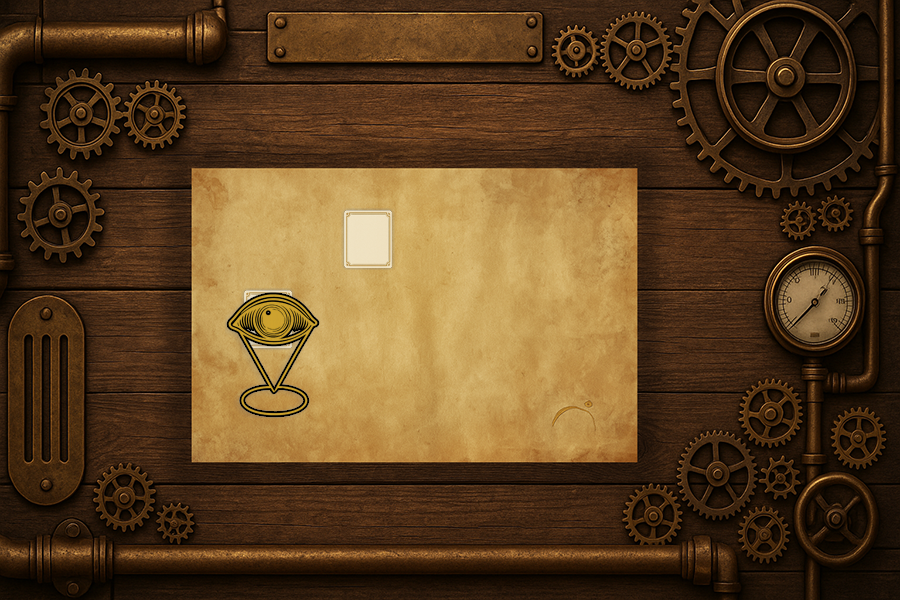

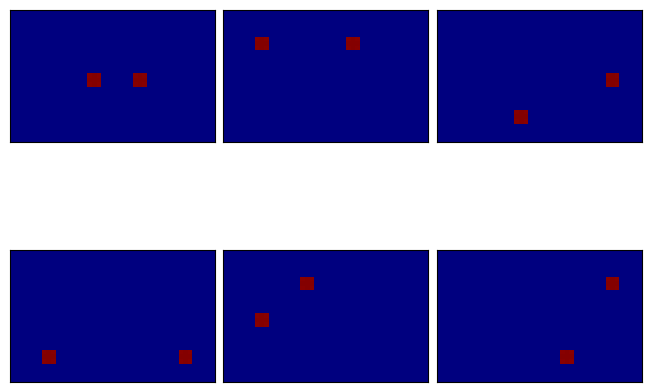

Saving buffers... done
Saving buffers... done
Saving buffers... done
Saving buffers... done
Saving buffers... done
Saving buffers... done
Saving buffers... done
Saving buffers... done
Saving buffers... done
Saving buffers... done
Saving buffers... done
Saving buffers... done
Saving buffers... done
Saving buffers... done
Saving buffers... done
Saving buffers... done
Saving buffers... done
Saving buffers... done
Saving buffers... done
Saving buffers... done
Saving buffers... done
Saving buffers... done
Saving buffers... done
Saving buffers... done
Saving buffers... done
Saving buffers... done
Saving buffers... done
Saving buffers... done
Saving buffers... done
Saving buffers... done
Saving buffers... done
Saving buffers... done
Saving buffers... done
Saving buffers... done
Saving buffers... done
Saving buffers... done
Saving buffers... done
Saving buffers... done
Saving buffers... done
Saving buffers... done
Saving buffers... done
Saving buffers... done
Saving buffers... done
Saving buff

In [5]:
if set_cl4:
    num_steps = 13000
else:
    num_steps = 8000
demo = demoMemoryGame(arch, perception_field="Attentional Selection")
recording = demo.run(num_steps)